# Project: Constant Therapy ESP Toy Project
**Project Description**: Playing with ESP for Constant Therapy  
**Experiment**: run for notebook and others  
**Run ID**: 4522  
**Notebook**: Neuro AI - Models Training

In [1]:
# Uncomment the following line and execute the cell to install this notebook's dependencies.
# You might need to restart the notebook's kernel.

# %pip install -r project_Constant_Therapy_ESP_Toy_Project_experiment_run_for_notebook_and_others_run_4522_requirements.txt

In [2]:
import joblib
import numbers
import os
import torch
import matplotlib.pyplot as plt
import numpy as np
from onnxruntime import InferenceSession
import pandas as pd
from abc import ABC
from abc import abstractmethod
from io import StringIO
from pandas.api.types import is_numeric_dtype
from typing import Any
from typing import Dict
from typing import List
from typing import Optional
from typing import Tuple
from typing import Type
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

from leaf_common.candidates.representation_types import RepresentationType
from leaf_common.representation.rule_based.config.rule_set_config_helper import RuleSetConfigHelper
from leaf_common.representation.rule_based.data.features import Features
from leaf_common.representation.rule_based.data.rule_set import RuleSet
from leaf_common.representation.rule_based.data.rule_set_binding import RuleSetBinding
from leaf_common.representation.rule_based.evaluation.rule_set_binding_evaluator import RuleSetBindingEvaluator
from leaf_common.representation.rule_based.persistence.rule_set_file_persistence import RuleSetFilePersistence
from esp_sdk.esp_evaluator import EspEvaluator
from esp_sdk.esp_service import EspService
from unileaf_util.framework.data.profiling.dataframe_profiler import DataFrameProfiler
from unileaf_util.framework.interfaces.data_frame_predictor import DataFramePredictor
from unileaf_util.framework.metrics.metrics_manager import MetricsManager
from unileaf_util.framework.transformers.data_encoder import DataEncoder
from unileaf_util.framework.transformers.rules_data_encoder import RulesDataEncoder

pd.set_option('display.max_columns', None)

## Load the dataset
By default, load the dataset exported with the notebook, but you may plug your own dataset by changing the path for DATASET_CSV here.

In [3]:
# Path to the dataset csv file
DATASET_CSV = 'esp_toy_real.csv' # loading the toy dataset to understand notebook flow
with open(DATASET_CSV) as df_file:
    data_source_df = pd.read_csv(df_file)
data_source_df.head() # as expected (be careful with how unnamed columns are handled later down the pipeline)

,target_d_1,target_d_2,target_d_3,target_d_4,target_d_5,target_d_6,target_d_7,target_d_8,target_d_9,target_d_10,target_d_11,target_d_12,target_d_13,target_d_14,d_1_score,d_1_ind,d_2_score,d_2_ind,d_3_score,d_3_ind,d_4_score,d_4_ind,d_5_score,d_5_ind,d_6_score,d_6_ind,d_7_score,d_7_ind,d_8_score,d_8_ind,d_9_score,d_9_ind,d_10_score,d_10_ind,d_11_score,d_11_ind,d_12_score,d_12_ind,d_13_score,d_13_ind,d_14_score,d_14_ind,d_1_next,d_2_next,d_3_next,d_4_next,d_5_next,d_6_next,d_7_next,d_8_next,d_9_next,d_10_next,d_11_next,d_12_next,d_13_next,d_14_next
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,1.0,1.0,0.0,0.0,0.000000,0.000000,0.00000,0.00000,1.000000,1.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.350533,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.350591,0.649409,1.0,1.0,0.0,0.0,1.000000,1.000000,1.00000,1.00000,1.000000,1.000000,0.000000,0.000000,1.0,1.0,0.000000,0.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,0.0,0.0,0.633744,0.608613,0.000000,0.00000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.350591,0.649409,1.0,1.0,1.0,1.0,0.633785,0.366215,0.60866,0.39134,1.000000,1.000000,0.000000,0.000000,0.0,0.0,1.000000,1.000000,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.429222,0.22866,0.0,0.00000,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.350591,0.649409,0.0,0.0,0.0,0.0,0.633785,0.366215,0.60866,0.39134,0.429268,0.570732,0.228671,0.771329,0.0,0.0,0.000000,0.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.0,0.71571,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.350591,0.649409,0.0,0.0,1.0,1.0,0.633785,0.366215,0.60866,0.39134,0.429268,0.570732,0.228671,0.771329,1.0,1.0,0.715747,0.284253,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.350533,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0


In [4]:
data_source_df.describe()

,target_d_1,target_d_2,target_d_3,target_d_4,target_d_5,target_d_6,target_d_7,target_d_8,target_d_9,target_d_10,target_d_11,target_d_12,target_d_13,target_d_14,d_1_score,d_1_ind,d_2_score,d_2_ind,d_3_score,d_3_ind,d_4_score,d_4_ind,d_5_score,d_5_ind,d_6_score,d_6_ind,d_7_score,d_7_ind,d_8_score,d_8_ind,d_9_score,d_9_ind,d_10_score,d_10_ind,d_11_score,d_11_ind,d_12_score,d_12_ind,d_13_score,d_13_ind,d_14_score,d_14_ind,d_1_next,d_2_next,d_3_next,d_4_next,d_5_next,d_6_next,d_7_next,d_8_next,d_9_next,d_10_next,d_11_next,d_12_next,d_13_next,d_14_next
count,5.421080e+06,5.421080e+06,5.421080e+06,5.421080e+06,5.421080e+06,5.421080e+06,5.421080e+06,5.421080e+06,5.421080e+06,5.421080e+06,5.421080e+06,5.421080e+06,5.421080e+06,5.421080e+06,5.421080e+06,5.421080e+06,5.421080e+06,5.421080e+06,5.421080e+06,5.421080e+06,5.421080e+06,5.421080e+06,5.421080e+06,5.421080e+06,5.421080e+06,5.421080e+06,5.421080e+06,5.421080e+06,5.421080e+06,5.421080e+06,5.421080e+06,5.421080e+06,5.421080e+06,5.421080e+06,5.421080e+06,5.421080e+06,5.421080e+06,5.421080e+06,5.421080e+06,5.421080e+06,5.421080e+06,5.421080e+06,5.421080e+06,5.421080e+06,5.421080e+06,5.421080e+06,5.421080e+06,5.421080e+06,5.421080e+06,5.421080e+06,5.421080e+06,5.421080e+06,5.421080e+06,5.421080e+06,5.421080e+06,5.421080e+06
mean,1.328152e-01,6.841201e-02,6.861898e-02,1.215688e-01,1.648260e-01,7.428815e-02,4.467449e-02,2.339220e-02,7.081043e-02,1.783180e-01,4.960709e-02,1.507386e-01,1.745608e-01,4.918596e-02,4.999680e-01,4.999678e-01,5.000419e-01,5.000417e-01,5.000201e-01,5.000199e-01,5.000667e-01,5.000665e-01,5.000061e-01,5.000059e-01,5.000564e-01,5.000563e-01,4.998169e-01,4.998167e-01,5.000167e-01,5.000165e-01,5.000462e-01,5.000460e-01,5.000239e-01,5.000237e-01,5.000364e-01,5.000362e-01,4.999970e-01,4.999968e-01,4.999928e-01,4.999926e-01,4.999686e-01,4.999684e-01,6.764606e-02,3.053321e-02,2.289610e-02,5.543838e-02,9.105107e-02,3.536466e-02,1.942094e-02,1.004051e-02,3.709631e-02,7.780830e-02,2.054880e-02,7.677670e-02,7.736515e-02,1.974831e-02
std,3.393750e-01,2.524516e-01,2.528051e-01,3.267871e-01,3.710235e-01,2.622393e-01,2.065882e-01,1.511457e-01,2.565079e-01,3.827802e-01,2.171318e-01,3.577939e-01,3.795910e-01,2.162561e-01,3.106582e-01,3.106582e-01,3.694401e-01,3.694401e-01,3.158354e-01,3.158354e-01,2.970283e-01,2.970283e-01,3.028900e-01,3.028900e-01,3.291659e-01,3.291659e-01,3.804437e-01,3.804437e-01,3.797930e-01,3.797930e-01,3.390040e-01,3.390040e-01,3.005643e-01,3.005643e-01,3.147676e-01,3.147676e-01,3.101200e-01,3.101200e-01,3.047899e-01,3.047899e-01,3.734140e-01,3.734140e-01,2.002987e-01,1.301363e-01,1.075216e-01,1.747503e-01,2.316377e-01,1.387329e-01,1.028618e-01,7.368721e-02,1.519436e-01,2.051430e-01,1.071867e-01,2.133143e-01,2.041830e-01,1.029349e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.177075e-01,2.297036e-01,1.460463e-01,9.998172e-02,2.144537e-01,1.966112e-01,2.478421e-01,2.414651e-01,2.365060e-01,2.363654e-01,2.043759e-01,2.054651e-01,1.060959e-01,6.877065e-02,5.312967e-02,1.768176e-01,1.805672e-01,1.931984e-01,2.384721e-01,2.410933e-01,2.071105e-01,2.605082e-01,2.241499e-01,2.320012e-01,2.337491e-01,2.367

## Encode the dataset
Encode the dataset using the fields definition from the Experiment's data source

In [5]:
profiler = DataFrameProfiler()
data_profile = profiler.profile_data_frame(data_source_df)

# Get fields from the data profile
fields = data_profile.get('info')

In [6]:
import IPython.display
IPython.display.JSON(fields)

<IPython.core.display.JSON object>

In [7]:
cao_mapping = {'context': ['d_1_ind', 'd_2_ind', 'd_3_ind', 'd_4_ind', 'd_5_ind', 'd_6_ind', 'd_7_ind', 'd_8_ind', 'd_9_ind', 'd_10_ind', 'd_11_ind', 'd_12_ind', 'd_13_ind', 'd_14_ind', 'd_1_score', 'd_2_score', 'd_3_score', 'd_4_score', 'd_5_score', 'd_6_score', 'd_7_score', 'd_8_score', 'd_9_score', 'd_10_score', 'd_11_score', 'd_12_score', 'd_13_score', 'd_14_score'], 'actions': ['target_d_1', 'target_d_2', 'target_d_3', 'target_d_4', 'target_d_5', 'target_d_6', 'target_d_7', 'target_d_8', 'target_d_9', 'target_d_10', 'target_d_11', 'target_d_12', 'target_d_13', 'target_d_14'], 'outcomes': ['derived_metric']}
cao_fields =  set(cao_mapping['context'] + cao_mapping['actions'] + cao_mapping['outcomes'])

# Validate if the fields match with cao_mapping
missing_fields = set(fields.keys()) - cao_fields # fields is a dictionary # type: ignore
extra_fields =  cao_fields - set(fields.keys()) # fields is a dictionary # type: ignore
if missing_fields != set():
    print(f'The dataset contains fields that are NOT part of cao_mapping: {missing_fields}')
    print('Please add them to the cao_mapping dictionary and make sure the rest of the notebook handles them correctly.')
if extra_fields != set():
    print(f'The cao_mapping contains fields that are NOT part of the dataset: {extra_fields}')
    print('Please remove them from the cao_mapping dictionary and make sure they are not used in the rest of the notebook.')

The dataset contains fields that are NOT part of cao_mapping: {'d_1_next', 'd_5_next', 'd_8_next', 'd_4_next', 'd_10_next', 'd_7_next', 'd_12_next', 'd_11_next', 'd_14_next', 'd_3_next', 'd_13_next', 'd_6_next', 'd_9_next', 'd_2_next'}
Please add them to the cao_mapping dictionary and make sure the rest of the notebook handles them correctly.
The cao_mapping contains fields that are NOT part of the dataset: {'derived_metric'}
Please remove them from the cao_mapping dictionary and make sure they are not used in the rest of the notebook.


In [8]:
import IPython.display
IPython.display.JSON(cao_mapping)

<IPython.core.display.JSON object>

In [9]:
next_cols = [f'd_{i}_next' for i in range(1, 15)]
missing = [c for c in next_cols if c not in data_source_df.columns]
assert not missing, f"Missing raw next-domain columns: {missing}"

# Example metric: average of 14 true next scores (replace with your formula)
data_source_df['derived_metric'] = data_source_df[next_cols].mean(axis=1).astype(float)

# Ensure 'derived_metric' exists in the fields dict so the encoder will build a transformer
# Clone the schema of an existing numeric next-domain column to be safe:
template_key = next_cols[0]  # e.g., 'd_1_next'
if 'derived_metric' not in fields:
    fields['derived_metric'] = dict(fields[template_key])
    # If your fields have a 'name' or 'original_name' key, update it:
    for k in ('name', 'original_name'):
        if k in fields['derived_metric']:
            fields['derived_metric'][k] = 'derived_metric'

In [10]:
encoder = DataEncoder(fields, cao_mapping) # fields is a dictionary # type: ignore
encoded_data_source_df = encoder.encode_as_df(data_source_df)
encoded_data_source_df.head()
assert 'derived_metric' in encoded_data_source_df.columns, "derived_metric missing from encoded_data_source_df"

In [11]:
encoded_data_source_df.head()

,target_d_1,target_d_2,target_d_3,target_d_4,target_d_5,target_d_6,target_d_7,target_d_8,target_d_9,target_d_10,target_d_11,target_d_12,target_d_13,target_d_14,d_1_score,d_1_ind,d_2_score,d_2_ind,d_3_score,d_3_ind,d_4_score,d_4_ind,d_5_score,d_5_ind,d_6_score,d_6_ind,d_7_score,d_7_ind,d_8_score,d_8_ind,d_9_score,d_9_ind,d_10_score,d_10_ind,d_11_score,d_11_ind,d_12_score,d_12_ind,d_13_score,d_13_ind,d_14_score,d_14_ind,d_1_next,d_2_next,d_3_next,d_4_next,d_5_next,d_6_next,d_7_next,d_8_next,d_9_next,d_10_next,d_11_next,d_12_next,d_13_next,d_14_next,derived_metric
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,1.0,1.0,0.0,0.0,0.000000,0.000000,0.00000,0.00000,1.000000,1.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.374349,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.026739
1,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.350591,0.649409,1.0,1.0,0.0,0.0,1.000000,1.000000,1.00000,1.00000,1.000000,1.000000,0.000000,0.000000,1.0,1.0,0.000000,0.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,0.0,0.0,0.670928,0.618553,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.094769
2,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.350591,0.649409,1.0,1.0,1.0,1.0,0.633785,0.366215,0.60866,0.39134,1.000000,1.000000,0.000000,0.000000,0.0,0.0,1.000000,1.000000,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.465756,0.245544,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.050184
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.350591,0.649409,0.0,0.0,0.0,0.0,0.633785,0.366215,0.60866,0.39134,0.429268,0.570732,0.228671,0.771329,0.0,0.0,0.000000,0.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.746461,0.0,0.0,0.0,0.0,0.0,0.054595
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.350591,0.649409,0.0,0.0,1.0,1.0,0.633785,0.366215,0.60866,0.39134,0.429268,0.570732,0.228671,0.771329,1.0,1.0,0.715747,0.284253,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.374349,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.026739


## Predictor code

In [12]:
## initiate global variables

REGRESSOR = 'regressor'
CLASSIFIER = 'classifier'
TYPES = [REGRESSOR, CLASSIFIER]
predictors_by_id = {}
model_metrics_by_id = {}

In [13]:
class PredictorType:
    """
    This class defines the type of Predictor Possible.
    """

    def __init__(self, predictor_type: str):
        """
        The constructor confirms if the type of predictor is supported.
        :param predictor_type: String describing a name for the type of the
        predictor.
        """
        assert predictor_type in TYPES, "Invalid Predictor Type"
        self.type = predictor_type

    def __str__(self) -> str:
        """
        This function overrides the string representation of the
        class.
        :return self.type: String
        """
        return self.type


In [14]:
class Predictor(DataFramePredictor, ABC):
    """
    This class contains the contract that any predictor
    must implement.
    """

    def __init__(self,
                 data_df: pd.DataFrame,
                 cao_mapping: Dict[str, List[str]],
                 data_split: Dict[str, float],
                 model_params: Dict = None, # type: ignore
                 metadata: Dict = None): # type: ignore
        """
        Initializes a predictor, its params and the metadata.
        :param data_df: DataFrame containing all processed data
        :param cao_mapping: a dictionary with `context`, `actions` and `outcomes`
        keys where each key returns a List of the selected column names as strings.
        :param data_split: Dictionary containing the training splits indexed
        by "train_pct" and "val_pct".
        :param model_params: Parameters of the model
        :param metadata: Dictionary describing any other information
        that must be stored along with the model.
        This might help in uniquely identifying the model
        :returns nothing
        """
        # Split the data between train, val and test sets
        self.data_split = data_split

        self.cao_mapping = cao_mapping
        self.context_actions_columns = self.cao_mapping["context"] + self.cao_mapping["actions"]
        # Check
        if len(cao_mapping["outcomes"]) > 1:
            if not self.does_support_multiobjective():
                raise ValueError(f"{self.predictor_name} does NOT support multiple outputs")

        self.column_length = {}
        if data_df is not None:
            train_df, val_df, test_df = self.generate_data_split(data_df, self.data_split)

            # Split the data between features (x) and labels(y)
            self.train_x_df, self.train_y_df = self.get_data_xy_split(train_df, cao_mapping)
            self.val_x_df, self.val_y_df = self.get_data_xy_split(val_df, cao_mapping)
            self.test_x_df, self.test_y_df = self.get_data_xy_split(test_df, cao_mapping)

            # Keep track of how many values are used to encode each outcome
            for column in self.cao_mapping["outcomes"]:
                first_value = self.train_y_df[column].head(1).values[0]
                if isinstance(first_value, numbers.Number):
                    # Value is a single scalar
                    self.column_length[column] = 1
                else:
                    # value is a one-hot encoded vector, i.e. a list. Get its size.
                    self.column_length[column] = len(self.train_y_df[column].head(1).values[0])
        else:
            # No data provided, assuming outcomes are numerical (not categorical)
            for column in self.cao_mapping["outcomes"]:
                self.column_length[column] = 1

        if model_params is None:
            model_params = {}
        self.model_params = model_params

        if metadata is None:
            metadata = {}
        self.metadata = metadata

        # Internal Parameters that are used to store the
        # latest state of the model.
        self._trained_model = None

    @property
    @abstractmethod
    def predictor_type(self) -> PredictorType:
        """
        :return the PredictorType of this Predictor: Regressor or Classifier
        """

    @property
    @abstractmethod
    def library(self) -> str:
        """
        :return the underlying library that implements this predictor, as a string
        """

    @property
    @abstractmethod
    def predictor_name(self) -> str:
        """
        :return: the name of the Predictor, as a string
        """

    @staticmethod
    @abstractmethod
    def does_support_multiobjective() -> bool:
        """
        This function returns if the predictor supports multiple outputs
        or not.
        :return multioutput: Bool
        """

    @abstractmethod
    def build_model(self, model_params: Dict):
        """
        This function must be overridden to build the model using the model
        parameters if desired and return a model.
        :param model_params: Dictionary containing the model parameters
        :return model: The built model.
        """

    @abstractmethod
    def train_model(self, model,
                    train_x: np.ndarray, train_y: np.ndarray,
                    val_x: Optional[np.ndarray], val_y: Optional[np.ndarray]) -> Type:
        """
        This function must be overridden to train the built model from the build_model step
        given the Data and must return the trained model.
        :param model: The model built in the build_model step
        :param train_x: numpy array containing the processed input features split for training
        :param train_y: numpy array containing the processed output features split for training
        :param val_x: Optional numpy array containing the processed input features split for validation
        :param val_y: Optional numpy array containing the processed output features split for validation

        :return trained_model
        """

    def set_trained_model(self, trained_model) -> None:
        """
        Sets the underlying trained model to the passed one.
        :param trained_model: a trained model
        :return Nothing:
        """
        self._trained_model = trained_model

    def get_trained_model(self):
        """
        Returns the trained model if it has been set, None otherwise
        :return self._trained_model:
        """
        return self._trained_model

    @staticmethod
    def generate_data_split(data_df: pd.DataFrame,
                            data_split: Dict[str, Any]) -> Tuple[pd.DataFrame, Optional[pd.DataFrame], pd.DataFrame]:
        """
        Splits the data between train, validation (optional) and test sets
        :param data_df: the full dataset as a Pandas DataFrame
        :param data_split: a dictionary with the
        :return: a tuple of Pandas DataFrame: one for train, one for validation (or None), and one for test
        """

        # First, split the data set in train and test sets.
        # Use the provided random_state, if any
        random_state = data_split.get("random_state", None)
        shuffle = data_split.get("shuffle", True)
        train_df, test_df = train_test_split(data_df,
                                             test_size=data_split["test_pct"],
                                             random_state=random_state,
                                             shuffle=shuffle)

        # If we also need a validation set, split the train set into train and validation sets.
        val_pct = data_split.get("val_pct", 0)
        if val_pct > 0:
            train_df, val_df = train_test_split(train_df,
                                                test_size=val_pct,
                                                random_state=random_state,
                                                shuffle=shuffle)
        else:
            val_df = None
        return train_df, val_df, test_df

    def predict(self, encoded_context_actions_df: pd.DataFrame) -> pd.DataFrame:
        """
        This method uses the trained model to make a prediction for the passed Pandas DataFrame
        of context and actions. Returns the predicted outcomes in a Pandas DataFrame.
        :param encoded_context_actions_df: a Pandas DataFrame containing encoded rows of context and actions for
        which a prediction is requested. Categorical columns contain one-hot vectors, e.g. [1, 0, 0]. Which means
        a row can be a list of arrays (1 per column), e.g.: [1, 0, 0], [1,0].
        :return a Pandas DataFrame of the predicted outcomes for each context and actions row.
        """
        # Default implementation
        if self._trained_model:
            # Predict using the model's input columns, in case encoded_context_actions_df contains more columns
            # or is in a different order
            context_action_df = encoded_context_actions_df[self.context_actions_columns]
            # Convert one-hot vector columns into a single feature vector
            features = DataEncoder.encoded_df_to_np(context_action_df)
            # Check if model type is onnx runtime or not
            if isinstance(self._trained_model, InferenceSession):
                predictions = self._trained_model.run(None, {"X": features.astype(np.float32)})[0]
            else:
                predictions = self._trained_model.predict(features)
            if isinstance(predictions, pd.DataFrame):
                # Predictions are already in a DataFrame. Make sure they have the correct outcome names
                predictions_df = predictions
                predictions_df.columns = self.cao_mapping["outcomes"]
                # Convert predictions to float64 as it's JSON serializable, while float32 is not
                predictions_df = predictions_df.astype("float64")
            else:
                # Assuming predictions is a ndarray, convert it to a DataFrame with the output column names
                predictions_df = DataEncoder.np_to_encoded_df(predictions,
                                                              self.column_length)
        else:
            raise ValueError("Can't make predictions because the model has not been trained")
        return predictions_df

    @staticmethod
    def export_metrics(metrics_dict: Dict[str, Any], file_path: str):
        """
        Save the model's training metrics to the specified location
        :param metrics_dict: a dictionary containing metrics
        :param file_path: the name and path of the file to persist the bytes to
        :return: nothing
        """
        with open(file_path, 'w', encoding='utf-8') as my_file:
            json.dump(metrics_dict, my_file)

    @staticmethod
    def get_data_xy_split(data_df: Optional[pd.DataFrame],
                          cao_mapping: Dict) -> Tuple[Optional[pd.DataFrame], Optional[pd.DataFrame]]:
        """
        This function takes a dataframe and a dictionary mapping indices to context,
        action, or outcome. This then splits the dataframe into two dataframes based
        on it's CAO tagging.

        data_x: Context and Actions
        data_y: Outcomes

        :param data_df: a Pandas DataFrame with all the data
        :param cao_mapping: a dictionary with `context`, `actions` and `outcomes` keys where each key returns a List
         ofthe selected column names as strings.
        :return: A tuple containing two dataframes: data_x with the features, and data_y with the labels (outcomes)
        """
        if data_df is None:
            return None, None

        data_x_df = data_df[cao_mapping["context"] + cao_mapping["actions"]]
        data_y_df = data_df[cao_mapping["outcomes"]]

        return data_x_df, data_y_df

    def __str__(self):
        return self.predictor_name


In [15]:
class Regressor(PredictorType):
    """
    This class defines a Regressor Type
    """

    def __init__(self):
        """
        The constructor initializes the super class.
        """
        super().__init__(REGRESSOR)


In [16]:
class Classifier(PredictorType):
    """
    This class defines a Classifier Type
    """

    def __init__(self):
        """
        The constructor initializes the super class.
        """
        super().__init__(CLASSIFIER)


## Predictor 704abc67-fe1c-409b-87c1-8e59864b7fe4
### CAO columns

In [17]:
CONTEXT_COLUMNS = ['d_1_ind', 'd_2_ind', 'd_3_ind', 'd_4_ind', 'd_5_ind', 'd_6_ind', 'd_7_ind', 'd_8_ind', 'd_9_ind', 'd_10_ind', 'd_11_ind', 'd_12_ind', 'd_13_ind', 'd_14_ind', 'd_1_score', 'd_2_score', 'd_3_score', 'd_4_score', 'd_5_score', 'd_6_score', 'd_7_score', 'd_8_score', 'd_9_score', 'd_10_score', 'd_11_score', 'd_12_score', 'd_13_score', 'd_14_score']
ACTION_COLUMNS = ['target_d_1', 'target_d_2', 'target_d_3', 'target_d_4', 'target_d_5', 'target_d_6', 'target_d_7', 'target_d_8', 'target_d_9', 'target_d_10', 'target_d_11', 'target_d_12', 'target_d_13', 'target_d_14']
OUTCOME_COLUMNS = ['derived_metric']
CONTEXT_ACTION_COLUMNS = CONTEXT_COLUMNS + ACTION_COLUMNS

### Data split

In [18]:
data_split = {"train_pct": 0.8, "test_pct": 0.2, "random_state": 42}

### Predictor code

In [19]:
class LinearRegression(Predictor):
    """
    This class implements a linear regression model from the SKLearn library.
    """
    predictor_type = Regressor()
    library = "sklearn"
    predictor_name = name = f"{library} Linear Regression"

    def __init__(self,
                 data_df: pd.DataFrame,
                 cao_mapping: Dict[str, List[str]],
                 data_split: Dict = None,
                 model_params: Dict = None,
                 metadata: Dict = None):
        """
        The constructor initializes the base params.
        """
        super().__init__(data_df=data_df,
                         cao_mapping=cao_mapping,
                         data_split=data_split,
                         model_params=model_params,
                         metadata=metadata)

    @staticmethod
    def does_support_multiobjective() -> bool:
        """
        This function returns if the predictor supports multiple outputs
        or not.
        :return multioutput: Bool
        """
        multioutput = True
        return multioutput

    def build_model(self, model_params: Dict[str, Any]) -> linear_model.LinearRegression:
        """
        This function instantiates a Linear Regression model with the given params.
        :return model: a LinearRegression instance
        """
        model = linear_model.LinearRegression(**model_params)
        return model

    def train_model(self, model: linear_model.LinearRegression,
                    train_x: np.ndarray, train_y: np.ndarray,
                    val_x: Optional[np.ndarray], val_y: Optional[np.ndarray])\
            -> linear_model.LinearRegression:
        """
        This function must be overridden to train the built model from the build_model step
        given the Data and must return the trained model and the desired metrics as a dictionary.
        :param model: The model built in the build_model step
        :param train_x: numpy array containing the processed input features split for training
        :param train_y: numpy array containing the processed output features split for training
        :param val_x: Optional numpy array containing the processed input features split for validation
        :param val_y: Optional numpy array containing the processed output features split for validation

        :return trained_model: The linear regression model trained
        """
        trained_model = model.fit(train_x, train_y)
        return trained_model


In [20]:
# ---- Base: your PyTorch 14-output model ---------------------------------------
class _TorchDomainPredictor(torch.nn.Module):
    def __init__(self, n_domains=14):
        super().__init__()
        self.n_domains = n_domains
        self.model = torch.nn.Sequential(
            torch.nn.Linear(n_domains * 3, 100),
            torch.nn.Sigmoid(),
            torch.nn.Linear(100, n_domains),
            torch.nn.Sigmoid()
        )
    def forward(self, x):
        return self.model(x)

class _TorchInferenceWrapper:
    def __init__(self, torch_model, device="cpu"):
        import torch
        self.m = torch_model.to(device).eval()
        self.device = device
        self.torch = torch
    def predict(self, X_np):
        with self.torch.no_grad():
            X = self.torch.from_numpy(X_np).float().to(self.device)
            Y = self.m(X).detach().cpu().numpy()  # shape (n, 14)
        return Y

class TorchRegressorPredictor(Predictor):
    predictor_type = Regressor()
    library = "pytorch"
    predictor_name = name = "PyTorch 14-output Regressor"

    @staticmethod
    def does_support_multiobjective() -> bool:
        return True  # 14 outputs

    def build_model(self, model_params):
        import torch
        n_domains = int(model_params.get("n_domains", 14))
        device = str(model_params.get("device", "cpu"))
        model = _TorchDomainPredictor(n_domains=n_domains)
        return {"model": model, "device": device}

    def train_model(self, model_bundle, train_x, train_y, val_x, val_y):
        import torch, os
        model_path = self.model_params.get("model_path")
        assert model_path and os.path.exists(model_path), f"model_path not found: {model_path}"
        model = model_bundle["model"]
        device = model_bundle["device"]
        state = torch.load(model_path, map_location=torch.device(device), weights_only=False)
        model.load_state_dict(state)
        return _TorchInferenceWrapper(model, device=device)

# ---- Wrapper: compute a single derived metric from the 14 predictions ----------
class DerivedMetricPredictor(Predictor):
    """
    Calls a 14-output base predictor, then maps the 14 ŷ to a 1D derived_metric.
    """
    predictor_type = Regressor()
    library = "meta"
    predictor_name = name = "Derived Metric from 14-output model"

    def __init__(self, *args, base_predictor=None, metric_name="derived_metric", metric_params=None, **kwargs):
        super().__init__(*args, **kwargs)
        assert base_predictor is not None, "Pass base_predictor=..."
        self.base_predictor = base_predictor
        self.metric_name = metric_name
        self.metric_params = metric_params or {}

    @staticmethod
    def does_support_multiobjective() -> bool:
        return False  # returns a single column

    def build_model(self, model_params):
        return None  # wrapper does not build a separate model

    def train_model(self, model, train_x, train_y, val_x, val_y):
        return self  # wrapper is already ready

    def predict(self, features_df_or_np):
        # 0) Ensure we have a DataFrame with the expected feature column order
        if isinstance(features_df_or_np, pd.DataFrame):
            X_df = features_df_or_np
        else:
            # Base class usually has self.context_actions_columns in order (context + actions)
            # If your base class exposes a different attribute, use that here.
            X_df = pd.DataFrame(features_df_or_np, columns=self.context_actions_columns)

        # 1) Get the 14 predictions from the base model as a DataFrame
        base_df = self.base_predictor.predict(X_df)     # shape (n, 14)
        yhat = base_df.to_numpy()                       # (n, 14)

        # 2) Extract actions and context as NumPy for fast indexing
        actions_cols = self.cao_mapping["actions"]      # length 14, ordered as your one-hot
        context_cols = self.cao_mapping["context"]      # expected like [d_1, d_1_ind, d_2, d_2_ind, ...]
        A = X_df[actions_cols].to_numpy(copy=False)     # (n, 14), values in {0,1}

        C = X_df[context_cols].to_numpy(copy=True)      # (n, 28) if alternating score/indicator
        # If your “context” really is pairs [score, indicator] per domain, take the score columns:
        # indices 0,2,4,...,26 → 14 columns
        score_idxs = np.arange(0, C.shape[1], 2)
        C_scores = C[:, score_idxs]                     # (n, 14) current scores by domain

        # 3) Replace current score with predicted value when the action for that domain == 1
        # Loop version (clear & fine for 14 columns)
        # for i in range(14):
        #     mask = (A[:, i] == 1)
        #     if mask.any():
        #         C_scores[mask, i] = yhat[mask, i]

        # Vectorized alternative (optional):
        # masks = (A == 1)
        # C_scores[masks] = yhat[masks]

        # 4) Replace d_i_score with yhat[:, i] where target_i == 1
        mask = (A == 1)                          # (n, 14) boolean/int
        replaced_scores = C_scores.copy()
        replaced_scores[mask] = yhat[mask]

        # 5) Average across all domains
        derived = replaced_scores.mean(axis=1)

        # 6) Return as a 1-col DataFrame with the expected outcome name
        return pd.DataFrame(derived, columns=[self.metric_name])

In [21]:
# predictor_node_id = '704abc67-fe1c-409b-87c1-8e59864b7fe4'
# predictor = LinearRegression(encoded_data_source_df,
#     cao_mapping={'context': ['d_1_ind', 'd_2_ind', 'd_3_ind', 'd_4_ind', 'd_5_ind', 'd_6_ind', 'd_7_ind', 'd_8_ind', 'd_9_ind', 'd_10_ind', 'd_11_ind', 'd_12_ind', 'd_13_ind', 'd_14_ind', 'd_1_score', 'd_2_score', 'd_3_score', 'd_4_score', 'd_5_score', 'd_6_score', 'd_7_score', 'd_8_score', 'd_9_score', 'd_10_score', 'd_11_score', 'd_12_score', 'd_13_score', 'd_14_score'], 'actions': ['target_d_1', 'target_d_2', 'target_d_3', 'target_d_4', 'target_d_5', 'target_d_6', 'target_d_7', 'target_d_8', 'target_d_9', 'target_d_10', 'target_d_11', 'target_d_12', 'target_d_13', 'target_d_14'], 'outcomes': ['d_3_next']},
# data_split=data_split,
# model_params={},
# metadata={})
# --- Instantiate base Torch predictor (14 outputs) + wrapper (1 derived output) ---
base_id    = "torch-base-14"
derived_id = "torch-derived-metric"

# outcomes for the BASE predictor: ensure order matches your model's 14 outputs
base_outcomes = [f'd_{i}_next' for i in range(1, 15)]

base_predictor = TorchRegressorPredictor(
    encoded_data_source_df,
    cao_mapping={**cao_mapping, "outcomes": base_outcomes},  # provide 14 names for base
    data_split=data_split,
    model_params={
        "model_path": "model.pt",   # <-- set this to your REAL weights path
        "device": "cpu",
        "n_domains": 14
    },
    metadata={"role": "base_14_output"}
)

predictor = DerivedMetricPredictor(
    encoded_data_source_df,
    cao_mapping=cao_mapping,  # ['derived_metric']
    data_split=data_split,
    model_params={},
    metadata={"role": "derived_objective"},
    base_predictor=base_predictor
)

predictor_node_id = derived_id

### Train Predictor

In [22]:
# Load Torch weights for base; initialize wrapper; register wrapper for ESP
train = True

# === Prepare features/targets just like Cell 26 ===
train_x = DataEncoder.encoded_df_to_np(predictor.train_x_df)
train_y = DataEncoder.encoded_df_to_np(predictor.train_y_df)
if predictor.val_x_df is not None:
    val_x = DataEncoder.encoded_df_to_np(predictor.val_x_df)
    val_y = DataEncoder.encoded_df_to_np(predictor.val_y_df)
else:
    val_x = val_y = None

# 1️⃣ Base: build and “train” (really just loads the state_dict)
_ = base_predictor.train_model(
        base_predictor.build_model(base_predictor.model_params),
        train_x, None, val_x, None)
base_predictor.set_trained_model(_)

# 2️⃣ Wrapper: build & finalize (no real training)
_ = predictor.train_model(
        predictor.build_model(predictor.model_params),
        train_x, train_y, val_x, val_y)
predictor.set_trained_model(_)

# 3️⃣ Register only the derived predictor for ESP
predictors_by_id[predictor_node_id] = predictor

### Predictor metrics

In [23]:
model_metrics_by_id[predictor_node_id] = [MetricsManager.get_calculator('Mean Squared Error')]
metrics = MetricsManager.compute_metrics(predictor,
model_metrics_by_id[predictor_node_id],predictor.train_x_df, predictor.train_y_df,predictor.val_x_df, predictor.val_y_df,predictor.test_x_df, predictor.test_y_df,encoder)

print(f'Predictor trained. Metrics: {metrics}')

Predictor trained. Metrics: {'train_Mean Squared Error_derived_metric': 0.14825767810716606, 'test_Mean Squared Error_derived_metric': 0.14816216841444516}


## Prescriptor

### Evaluation code

In [24]:
class UnileafPrescriptor(EspEvaluator):
    """
    An Unileaf Prescriptor makes prescriptions given an ESP candidate and a context DataFrame.
    It is also an EspEvaluator implementation that returns metrics for ESP candidates.
    """

    def __init__(self,
                 config: Dict[str, Any],
                 evaluation_df: pd.DataFrame,
                 data_encoder: DataEncoder,
                 predictors: List[Predictor]):
        """
        Constructs a prescriptor evaluator
        :param config: the ESP experiment config dictionary
        :param evaluation_df: the Pandas DataFrame to use to evaluate the candidates
        :param data_encoder: the DataEncoder used to encode the dataset
        :param predictors: the predictors this prescriptor relies on
        """
        # Instantiate EspEvaluator
        # Note: sets self.config
        super().__init__(config)

        # CAO
        self.cao_mapping = {"context": self.get_context_field_names(config),
                            "actions": self.get_action_field_names(config),
                            "outcomes": self.get_fitness_metrics(config)}
        self.context_df = evaluation_df[self.cao_mapping["context"]]
        self.row_index = self.context_df.index

        # Convert the context DataFrame to a format a NN can ingest
        self.context_as_nn_input = self.convert_to_nn_input(self.context_df)

        # Data encoder
        self.data_encoder = data_encoder

        # Predictors
        self.predictors = predictors

    @staticmethod
    def convert_to_nn_input(context_df: pd.DataFrame) -> List[np.ndarray]:
        """
        Converts a context DataFrame to a list of numpy arrays a neural network can ingest
        :param context_df: a DataFrame containing inputs for a neural network. Number of inputs and size must match
        :return: a list of numpy ndarray, on ndarray per neural network input
        """
        # The NN expects a list of i inputs by s samples (e.g. 9 x 299).
        # So convert the data frame to a numpy array (gives shape 299 x 9), transpose it (gives 9 x 299)
        # and convert to list(list of 9 arrays of 299)
        context_as_nn_input = list(context_df.to_numpy().transpose())
        # Convert each column's list of 1D array to a 2D array
        context_as_nn_input = [np.stack(context_as_nn_input[i], axis=0) for i in
                               range(len(context_as_nn_input))]
        return context_as_nn_input

    def evaluate_candidate(self, candidate):
        """
        Evaluates a single Prescriptor candidate and returns its metrics.
        Implements the EspEvaluator interface
        :param candidate: a Keras neural network or rule based Prescriptor candidate
        :return metrics: A dictionary of {'metric_name': metric_value}
        """
        # Prescribe actions
        prescribed_actions_df = self.prescribe(candidate)

        # Aggregate the context and actions dataframes.
        context_actions_df = pd.concat([self.context_df,
                                        prescribed_actions_df],
                                       axis=1)

        # Compute the metrics
        metrics = self._compute_metrics(context_actions_df)
        return metrics

    def _compute_metrics(self, context_actions_df):
        """
        Computes metrics from the passed context/actions DataFrame using the instance's trained predictors.
        :param context_actions_df: a DataFrame of context / prescribed actions
        :return: A dictionary of {'metric_name': metric_value}
        """
        # Get the predicted outcomes from the predictors
        metrics = {}
        for predictor in self.predictors:
            predicted_outcomes = predictor.predict(context_actions_df)

            # UN-853: Decode predictions before computing numerical metrics, if a data_encoder is available
            if self.data_encoder is not None:
                decoded_predicted_outcomes = self.data_encoder.decode_as_df(predicted_outcomes)
            else:
                decoded_predicted_outcomes = predicted_outcomes

            # Only add a metric for the outcomes the prescriptor is interested in
            for outcome in self.cao_mapping["outcomes"]:
                # Add the metrics that have been produced by this predictor
                if outcome in predictor.cao_mapping["outcomes"]:
                    # Check the type of metric: numerical or categorical?
                    if decoded_predicted_outcomes[[outcome]].iloc[:, 0].dtype == object:
                        # Categorical outcome. Use the *encoded* predicted outcome.
                        preds = predicted_outcomes[outcome]
                        # Classifiers return the category's index in the list of categories, so we can take the mean
                        # of the encoded outcomes. Note: this works because Outcomes are encoded using LabelEncoder
                        # AND the user defined order for each Outcome categories.
                        metrics[outcome] = preds.mean()
                    else:
                        # UN-853: Numerical outcome. Use the *decoded*, i.e. scaled back, predicted outcome
                        preds = decoded_predicted_outcomes[outcome]
                        # Regressors produce floats: take the mean of the decoded outcome
                        metrics[outcome] = preds.mean()
        return metrics

    def prescribe(self, candidate, context_df: pd.DataFrame = None) -> pd.DataFrame:
        """
        Generates prescriptions using the passed candidate and context
        :param candidate: an ESP candidate, either neural network or rules
        :param context_df: a DataFrame containing the context to prescribe for,
         or None to use the instance one
        :return: a DataFrame containing actions prescribed for each context
        """
        if context_df is None:
            # No context is provided, use the instance's one
            context_as_nn_input = self.context_as_nn_input
            row_index = self.row_index
        else:
            # Convert the context DataFrame to something more suitable for neural networks
            context_as_nn_input = self.convert_to_nn_input(context_df)
            # Use the context's row index
            row_index = context_df.index

        is_rule_based = isinstance(candidate, RuleSet)
        if is_rule_based:
            actions = self._prescribe_from_rules(candidate, context_as_nn_input)
        else:
            actions = self._prescribe_from_nn(candidate, context_as_nn_input)

        # Convert the prescribed actions to a DataFrame
        prescribed_actions_df = pd.DataFrame(actions,
                                             columns=self.cao_mapping["actions"],
                                             index=row_index)
        
        # --- BEGIN: normalize array-valued action columns to scalars ---
        actions = self.cao_mapping["actions"]  # e.g., ['target_d_1', ..., 'target_d_14']

        for i, col in enumerate(actions):
            def to_scalar(v):
                # Scalar or None -> coerce to {0,1}
                if isinstance(v, (int, float, np.integer, np.floating)) or v is None:
                    return int(bool(v)) if v is not None and v == v else 0

                # Array/list -> pick i-th element (0-indexed: i=0 -> target_d_1)
                arr = np.asarray(v).ravel()
                if arr.size > i:
                    return int(arr[i] >= 0.5)

                # Fallback if array is shorter than expected:
                # mark "on" if any element >= 0.5 (conservative)
                return int(np.any(arr >= 0.5))

            prescribed_actions_df[col] = prescribed_actions_df[col].map(to_scalar).astype(int)

# Optional sanity: ensure all actions are 0/1 scalars now
# assert set(np.unique(prescribed_actions_df[actions].to_numpy())).issubset({0, 1})
# --- END: normalize array-valued action columns ---

        # Optional debug: confirm no arrays remain
        # print("array-valued left:",
        #       prescribed_actions_df[actions].apply(lambda s: s.apply(lambda v: isinstance(v,(list,tuple,np.ndarray)))).any())

        # --- END: normalize array-valued action columns ---


        # ### DEBUG:
        # print("-------------DEBUG: Prescribed Actions (encoded):")
        # print("shape: ", prescribed_actions_df.shape)
        # print("dtype: ", prescribed_actions_df.dtypes)
        # has_arrays = prescribed_actions_df.applymap(lambda x: isinstance(x, (list, np.ndarray))).any() # type: ignore
        # print("array-valued columns:\n", has_arrays[has_arrays].index.tolist())

        # UN-2430 Decode the sigmoides, if any, back into categories
        prescribed_actions_df = self.data_encoder.decode_as_df(prescribed_actions_df)
        # UN0-240 Re-encode the actions into what the predictors expect (e.g. one-hots for categorical data)
        prescribed_actions_df = self.data_encoder.encode_as_df(prescribed_actions_df)
        return prescribed_actions_df

    def _prescribe_from_rules(self, candidate, context_as_nn_input: List[np.ndarray]):
        """
        Generates prescriptions using the passed rules model candidate and context
        :param candidate: a rules model candidate
        :param context_as_nn_input: a numpy array containing the context to prescribe for
        :return: a dictionary of action name to list of action values
        """
        cand_states = RuleSetConfigHelper.get_states(self.config)
        cand_actions = RuleSetConfigHelper.get_actions(self.config)
        candidate = RuleSetBinding(candidate, cand_states, cand_actions)
        rules_encoder = RulesDataEncoder(candidate.actions)
        evaluator = RuleSetBindingEvaluator()
        rules_input = rules_encoder.encode_to_rules_data(context_as_nn_input)
        rules_output = evaluator.evaluate(candidate, rules_input)
        actions = rules_encoder.decode_from_rules_data(rules_output)
        return actions

    def _prescribe_from_nn(self, candidate, context_as_nn_input: List[np.ndarray]) -> Dict[str, Any]:
        """
        Generates prescriptions using the passed neural network candidate and context
        :param candidate: a Keras neural network candidate
        :param context_as_nn_input: a numpy array containing the context to prescribe for
        :return: a dictionary of action name to action value or list of action values
        """
        # Get the prescribed actions
        prescribed_actions = candidate.predict(context_as_nn_input)
        actions = {}

        if self._is_single_action_prescriptor():
            # Put the single action in an array to process it like multiple actions
            prescribed_actions = [prescribed_actions]

        for index, action_col in enumerate(self.cao_mapping["actions"]):
            if self._is_scalar(prescribed_actions[index]):
                # We have a single row and this action is numerical. Convert it to a scalar.
                actions[action_col] = prescribed_actions[index].item()
            else:
                actions[action_col] = prescribed_actions[index].tolist()
        return actions

    def _is_single_action_prescriptor(self):
        """
        Checks how many Actions have been defined in the Context, Actions, Outcomes mapping.
        :return: True if only 1 action is defined, False otherwise
        """
        return len(self.cao_mapping["actions"]) == 1

    @staticmethod
    def _is_scalar(prescribed_action):
        """
        Checks if the prescribed action contains a single value, i.e. a scalar, or an array.
        A prescribed action contains a single value if it has been prescribed for a single context sample
        :param prescribed_action: a scalar or an array
        :return: True if the prescribed action contains a scalar, False otherwise.
        """
        return prescribed_action.shape[0] == 1 and prescribed_action.shape[1] == 1

    @staticmethod
    def get_context_field_names(config: Dict[str, Any]) -> List[str]:
        """
        Returns the list of Context column names
        :param config: the ESP experiment config dictionary
        :return: the list of Context column names
        """
        nn_inputs = config["network"]["inputs"]
        contexts = [nn_input["name"] for nn_input in nn_inputs]
        return contexts

    @staticmethod
    def get_action_field_names(config: Dict[str, Any]) -> List[str]:
        """
        Returns the list of Action column names
        :param config: the ESP experiment config dictionary
        :return: the list of Action column names
        """
        nn_outputs = config["network"]["outputs"]
        actions = [nn_output["name"] for nn_output in nn_outputs]
        return actions

    @staticmethod
    def get_fitness_metrics(config: Dict[str, Any]) -> List[str]:
        """
        Returns the list of fitness metric names (Outcomes) to optimize.
        :param config: the ESP experiment config dictionary
        :return: the list of fitness metric names
        """
        metrics = config["evolution"]["fitness"]
        fitness_metrics = [metric["metric_name"] for metric in metrics]
        return fitness_metrics


### Prescriptor training

In [25]:
config = {'evolution': {'fitness': [{'maximize': True, 'metric_name': 'derived_metric'}], 'nb_elites': 1, 'mutation_type': 'gaussian_noise_percentage', 'nb_generations': 2, 'mutation_factor': 0.1, 'population_size': 3, 'parent_selection': 'tournament', 'initialization_range': 1, 'mutation_probability': 0.1, 'remove_population_pct': 0.8, 'initialization_distribution': 'orthogonal'}, 'network': {'inputs': [{'name': 'd_1_ind', 'size': 1, 'values': ['float']}, {'name': 'd_2_ind', 'size': 1, 'values': ['float']}, {'name': 'd_3_ind', 'size': 1, 'values': ['float']}, {'name': 'd_4_ind', 'size': 1, 'values': ['float']}, {'name': 'd_5_ind', 'size': 1, 'values': ['float']}, {'name': 'd_6_ind', 'size': 1, 'values': ['float']}, {'name': 'd_7_ind', 'size': 1, 'values': ['float']}, {'name': 'd_8_ind', 'size': 1, 'values': ['float']}, {'name': 'd_9_ind', 'size': 1, 'values': ['float']}, {'name': 'd_10_ind', 'size': 1, 'values': ['float']}, {'name': 'd_11_ind', 'size': 1, 'values': ['float']}, {'name': 'd_12_ind', 'size': 1, 'values': ['float']}, {'name': 'd_13_ind', 'size': 1, 'values': ['float']}, {'name': 'd_14_ind', 'size': 1, 'values': ['float']}, {'name': 'd_1_score', 'size': 1, 'values': ['float']}, {'name': 'd_2_score', 'size': 1, 'values': ['float']}, {'name': 'd_3_score', 'size': 1, 'values': ['float']}, {'name': 'd_4_score', 'size': 1, 'values': ['float']}, {'name': 'd_5_score', 'size': 1, 'values': ['float']}, {'name': 'd_6_score', 'size': 1, 'values': ['float']}, {'name': 'd_7_score', 'size': 1, 'values': ['float']}, {'name': 'd_8_score', 'size': 1, 'values': ['float']}, {'name': 'd_9_score', 'size': 1, 'values': ['float']}, {'name': 'd_10_score', 'size': 1, 'values': ['float']}, {'name': 'd_11_score', 'size': 1, 'values': ['float']}, {'name': 'd_12_score', 'size': 1, 'values': ['float']}, {'name': 'd_13_score', 'size': 1, 'values': ['float']}, {'name': 'd_14_score', 'size': 1, 'values': ['float']}], 'outputs': [{'name': 'target_d_1', 'size': 2, 'activation': 'sigmoid', 'use_bias': True, 'values': ['0.0', '1.0']}, {'name': 'target_d_2', 'size': 2, 'activation': 'sigmoid', 'use_bias': True, 'values': ['0.0', '1.0']}, {'name': 'target_d_3', 'size': 2, 'activation': 'sigmoid', 'use_bias': True, 'values': ['0.0', '1.0']}, {'name': 'target_d_4', 'size': 2, 'activation': 'sigmoid', 'use_bias': True, 'values': ['0.0', '1.0']}, {'name': 'target_d_5', 'size': 2, 'activation': 'sigmoid', 'use_bias': True, 'values': ['0.0', '1.0']}, {'name': 'target_d_6', 'size': 2, 'activation': 'sigmoid', 'use_bias': True, 'values': ['0.0', '1.0']}, {'name': 'target_d_7', 'size': 2, 'activation': 'sigmoid', 'use_bias': True, 'values': ['0.0', '1.0']}, {'name': 'target_d_8', 'size': 2, 'activation': 'sigmoid', 'use_bias': True, 'values': ['0.0', '1.0']}, {'name': 'target_d_9', 'size': 2, 'activation': 'sigmoid', 'use_bias': True, 'values': ['0.0', '1.0']}, {'name': 'target_d_10', 'size': 2, 'activation': 'sigmoid', 'use_bias': True, 'values': ['0.0', '1.0']}, {'name': 'target_d_11', 'size': 2, 'activation': 'sigmoid', 'use_bias': True, 'values': ['0.0', '1.0']}, {'name': 'target_d_12', 'size': 2, 'activation': 'sigmoid', 'use_bias': True, 'values': ['0.0', '1.0']}, {'name': 'target_d_13', 'size': 2, 'activation': 'sigmoid', 'use_bias': True, 'values': ['0.0', '1.0']}, {'name': 'target_d_14', 'size': 2, 'activation': 'sigmoid', 'use_bias': True, 'values': ['0.0', '1.0']}], 'hidden_layers': [{'layer_name': 'hidden_1', 'layer_type': 'Dense', 'layer_params': {'units': 16, 'use_bias': True, 'activation': 'tanh'}}]}, 'LEAF': {'representation': 'NNWeights', 'experiment_id': 'UniLEAF_de95fcd7-7056-43d3-9e30-9d309e76f726', 'version': '1.0.0', 'persistence_dir': 'trained_prescriptors/', 'candidates_to_persist': 'best'}}

In [26]:
import IPython.display
IPython.display.JSON(config)

<IPython.core.display.JSON object>

In [27]:
# required_predictor_ids = ['704abc67-fe1c-409b-87c1-8e59864b7fe4']
# all_predictors = [predictors_by_id[required_id] for required_id in required_predictor_ids]
required_predictor_ids = ['torch-derived-metric']
all_predictors = [predictors_by_id[required_id] for required_id in required_predictor_ids]

In [28]:
# Instantiate the EspService
esp_service = EspService(config)
esp_evaluator = UnileafPrescriptor(config,
                                   encoded_data_source_df,
                                   encoder,
                                   all_predictors)
experiment_results_dir = esp_service.train(esp_evaluator)

Starting training:
  experiment_id: UniLEAF_de95fcd7-7056-43d3-9e30-9d309e76f726
  checkpoint_id: None
  timestamp: 20251027-182409
Asking ESP for a seed generation...
Seed generation received.
Evaluating PopulationResponse for generation 1...:
PopulationResponse:
  Generation: 1
  Population size: 3
  Checkpoint id: UniLEAF_de95fcd7-7056-43d3-9e30-9d309e76f726/1/20251028-012409
Evaluating candidates synchronously because max_workers == 0
169409/169409 ━━━━━━━━━━━━━━━━━━━━ 132s 780us/step
169409/169409 ━━━━━━━━━━━━━━━━━━━━ 134s 788us/step
169409/169409 ━━━━━━━━━━━━━━━━━━━━ 128s 754us/step


Evaluation done.
Reporting evaluated population for generation 1 and asking ESP for generation 2...:
Generation 1 data persisted.
Evaluated candidates:
Id: 1_1 Identity: {'ancestor_count': 0, 'ancestor_ids': [], 'birth_generation': 1, 'domain_name': None, 'experiment_version': 'UniLEAF_de95fcd7-7056-43d3-9e30-9d309e76f726', 'unique_id': '1_1', 'origin': '(none)'} Metrics: ['derived_metric: 0.07089484471533113', 'is_elite: False']
Id: 1_2 Identity: {'ancestor_count': 0, 'ancestor_ids': [], 'birth_generation': 1, 'domain_name': None, 'experiment_version': 'UniLEAF_de95fcd7-7056-43d3-9e30-9d309e76f726', 'unique_id': '1_2', 'origin': '(none)'} Metrics: ['derived_metric: 0.1531074900008744', 'is_elite: False']
Id: 1_3 Identity: {'ancestor_count': 0, 'ancestor_ids': [], 'birth_generation': 1, 'domain_name': None, 'experiment_version': 'UniLEAF_de95fcd7-7056-43d3-9e30-9d309e76f726', 'unique_id': '1_3', 'origin': '(none)'} Metrics: ['derived_metric: 0.16948839342022176', 'is_elite: True']

Don

Evaluation done.
Reporting evaluated population for generation 2...
Generation 2 data persisted.
Evaluated candidates:
Id: 2_3 Identity: {'ancestor_count': 1, 'ancestor_ids': ['1_3', '1_3'], 'birth_generation': 2, 'domain_name': None, 'experiment_version': 'UniLEAF_de95fcd7-7056-43d3-9e30-9d309e76f726', 'unique_id': '2_3', 'origin': '1_3~CUW~1_3#MGNP'} Metrics: ['derived_metric: 0.16845250952254517', 'is_elite: False']
Id: 1_3 Identity: {'ancestor_count': 0, 'ancestor_ids': [], 'birth_generation': 1, 'domain_name': None, 'experiment_version': 'UniLEAF_de95fcd7-7056-43d3-9e30-9d309e76f726', 'unique_id': '1_3', 'origin': '(none)'} Metrics: ['derived_metric: 0.16948839342022176', 'is_elite: False']
Id: 2_2 Identity: {'ancestor_count': 1, 'ancestor_ids': ['1_3', '1_3'], 'birth_generation': 2, 'domain_name': None, 'experiment_version': 'UniLEAF_de95fcd7-7056-43d3-9e30-9d309e76f726', 'unique_id': '2_2', 'origin': '1_3~CUW~1_3#MGNP'} Metrics: ['derived_metric: 0.1714810474260885', 'is_elite: 

## ESP Summary Stats
esp_service.train(...) returned the directory in which the experiment results are stored

In [29]:
stats_file = os.path.join(experiment_results_dir, 'experiment_stats.csv')
with open(stats_file) as csv_file:
    stats_df = pd.read_csv(csv_file, sep=',')
stats_df

,generation,checkpoint_id,max_derived_metric,min_derived_metric,mean_derived_metric,elites_mean_derived_metric,cid_min_derived_metric,cid_max_derived_metric
0,1,UniLEAF_de95fcd7-7056-43d3-9e30-9d309e76f726/1...,0.169488,0.070895,0.131164,0.169488,1_1,1_3
1,2,UniLEAF_de95fcd7-7056-43d3-9e30-9d309e76f726/2...,0.171481,0.168453,0.169807,0.171481,2_3,2_2


## ESP Summary Plot
esp_service.train(...) generated a plot summarizing the experiment's progress

In [30]:
from IPython.display import Image

### derived_metric

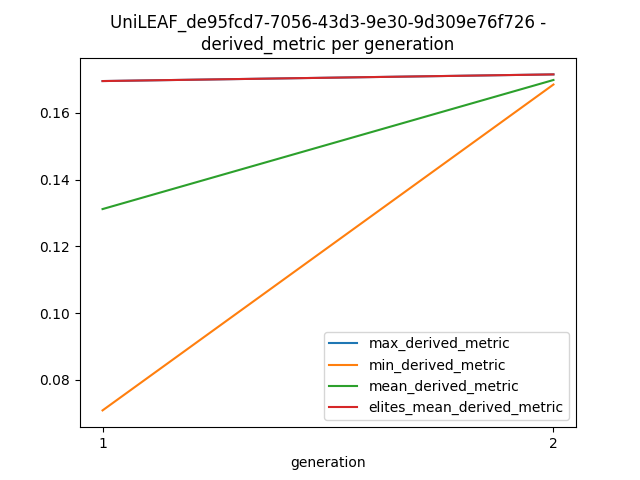

In [31]:
plot_file = os.path.join(experiment_results_dir, 'derived_metric_plot.png')
Image(filename=plot_file)

# Models usage
## Load the Prescriptor

In [32]:
# Use the last row of the stats DataFrame, i.e. the last generation, to find the best model
last_gen = stats_df['generation'].iloc[-1]
best_score = stats_df['max_derived_metric'].iloc[-1]
cid_best_score = stats_df['cid_max_derived_metric'].iloc[-1]
prescriptor_model_filename = os.path.join(experiment_results_dir,
                                          str(last_gen),
                                          cid_best_score + '.h5')
print(f'Best max_derived_metric average is {best_score:.3f} for candidate id {cid_best_score}')

Best max_derived_metric average is 0.171 for candidate id 2_2


In [33]:
from keras.models import load_model

print(f'Loading prescriptor model: {prescriptor_model_filename}')
prescriptor_model = load_model(prescriptor_model_filename, compile=False)

Loading prescriptor model: trained_prescriptors/UniLEAF_de95fcd7-7056-43d3-9e30-9d309e76f726/1.0.0_20251027-182409/2/2_2.h5


## Get a sample context
Get the context from one of the rows in the dataset, and make a prescription for it.

In [34]:
sample_df = data_source_df.sample(1)
sample_context_df = sample_df[CONTEXT_COLUMNS]
sample_context_action_df = sample_df[CONTEXT_ACTION_COLUMNS]
sample_df

,target_d_1,target_d_2,target_d_3,target_d_4,target_d_5,target_d_6,target_d_7,target_d_8,target_d_9,target_d_10,target_d_11,target_d_12,target_d_13,target_d_14,d_1_score,d_1_ind,d_2_score,d_2_ind,d_3_score,d_3_ind,d_4_score,d_4_ind,d_5_score,d_5_ind,d_6_score,d_6_ind,d_7_score,d_7_ind,d_8_score,d_8_ind,d_9_score,d_9_ind,d_10_score,d_10_ind,d_11_score,d_11_ind,d_12_score,d_12_ind,d_13_score,d_13_ind,d_14_score,d_14_ind,d_1_next,d_2_next,d_3_next,d_4_next,d_5_next,d_6_next,d_7_next,d_8_next,d_9_next,d_10_next,d_11_next,d_12_next,d_13_next,d_14_next,derived_metric
4221013,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.568639,0.431361,0.403811,0.596189,0.803389,0.196611,0.663684,0.336316,0.655638,0.344362,0.052795,0.947205,0.0,0.0,0.48153,0.51847,0.373895,0.626105,0.123285,0.876715,0.227337,0.772663,0.02006,0.97994,0.031734,0.968266,0.428786,0.571214,0.0,0.0,0.0,0.0,0.0,0.052782,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00377


### Prescribe


In [35]:
encoded_sample_context_df = encoder.encode_as_df(sample_context_df)
encoded_prescribed_actions_df = esp_evaluator.prescribe(prescriptor_model, encoded_sample_context_df)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


In [36]:
# Aggregate the context and actions dataframes.
encoded_context_actions_df = pd.concat([encoded_sample_context_df,
                                        encoded_prescribed_actions_df],
                                       axis=1)
sample_context_prescribed_action_df = encoder.decode_as_df(encoded_context_actions_df)
sample_context_prescribed_action_df

,d_1_ind,d_2_ind,d_3_ind,d_4_ind,d_5_ind,d_6_ind,d_7_ind,d_8_ind,d_9_ind,d_10_ind,d_11_ind,d_12_ind,d_13_ind,d_14_ind,d_1_score,d_2_score,d_3_score,d_4_score,d_5_score,d_6_score,d_7_score,d_8_score,d_9_score,d_10_score,d_11_score,d_12_score,d_13_score,d_14_score,target_d_1,target_d_2,target_d_3,target_d_4,target_d_5,target_d_6,target_d_7,target_d_8,target_d_9,target_d_10,target_d_11,target_d_12,target_d_13,target_d_14
0,0.431361,0.596189,0.196611,0.336316,0.344362,0.947205,0.0,0.51847,0.626105,0.876715,0.772663,0.97994,0.968266,0.571214,0.568639,0.403811,0.803389,0.663684,0.655638,0.052795,0.0,0.48153,0.373895,0.123285,0.227337,0.02006,0.031734,0.428786,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0


### Make predictions


In [37]:
def get_predictions(predictors, context_action_df, encoder):
    pred_array = []
    for predictor in predictors:
        pred = predictor.predict(encoder.encode_as_df(context_action_df))
        pred_array.append(encoder.decode_as_df(pred))
    preds_df = pd.concat(pred_array, axis=1)
    return preds_df

#### With original actions

In [38]:
original_actions_preds = get_predictions(all_predictors, sample_context_action_df, encoder)
original_actions_preds

,derived_metric
0,0.351854


#### With prescribed actions

In [39]:
prescribed_actions_preds = get_predictions(all_predictors, sample_context_prescribed_action_df, encoder)
prescribed_actions_preds

,derived_metric
0,0.135277


#### With custom actions

In [40]:
sample_context_custom_action_df = sample_context_prescribed_action_df.copy()
 # TODO: Uncomment and replace by the name of the actions(s) to customize
# sample_context_custom_action_df['SOME_ACTION_TO_CUSTOMIZE'] = 42
sample_context_custom_action_df

,d_1_ind,d_2_ind,d_3_ind,d_4_ind,d_5_ind,d_6_ind,d_7_ind,d_8_ind,d_9_ind,d_10_ind,d_11_ind,d_12_ind,d_13_ind,d_14_ind,d_1_score,d_2_score,d_3_score,d_4_score,d_5_score,d_6_score,d_7_score,d_8_score,d_9_score,d_10_score,d_11_score,d_12_score,d_13_score,d_14_score,target_d_1,target_d_2,target_d_3,target_d_4,target_d_5,target_d_6,target_d_7,target_d_8,target_d_9,target_d_10,target_d_11,target_d_12,target_d_13,target_d_14
0,0.431361,0.596189,0.196611,0.336316,0.344362,0.947205,0.0,0.51847,0.626105,0.876715,0.772663,0.97994,0.968266,0.571214,0.568639,0.403811,0.803389,0.663684,0.655638,0.052795,0.0,0.48153,0.373895,0.123285,0.227337,0.02006,0.031734,0.428786,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0


In [41]:
custom_actions_preds = get_predictions(all_predictors, sample_context_custom_action_df, encoder)
custom_actions_preds

,derived_metric
0,0.135277


### Compare
Compare 3 rows in a single table:
- the original sample
- the sample with the prescribed actions
- the sample with some custom actions

In [42]:
OUTCOME_COLUMNS = list(original_actions_preds.columns)
OUTCOME_COLUMNS

['derived_metric']

In [43]:
# Observed OUTCOMES for the sample
pd.DataFrame(sample_df[OUTCOME_COLUMNS])

,derived_metric
4221013,0.00377


In [44]:
# Context and actions for 3 rows:
# - the original sample
# - the sample with the prescribed actions
# - the sample with some custom actions
comp_df = pd.concat([sample_context_action_df,
                     sample_context_prescribed_action_df,
                     sample_context_custom_action_df], axis=0)

# Compute the outcomes
outcomes_dict = {}
for outcome in OUTCOME_COLUMNS:
    # Observed outcome from the sample in the dataset
    outcomes_dict[outcome] = [sample_df[outcome].iloc[0],
                              sample_df[outcome].iloc[0],
                              sample_df[outcome].iloc[0]]
    # Predicted outcome
    outcomes_dict[f'{outcome}_predicted'] = [original_actions_preds[outcome].iloc[0],
                                             prescribed_actions_preds[outcome].iloc[0],
                                             custom_actions_preds[outcome].iloc[0]]
    # For numerical outcomes, compute the diff between predicted and observed
    if is_numeric_dtype(outcomes_dict[outcome][0]):
        diff = [a - b for a, b in zip(outcomes_dict[f'{outcome}_predicted'],
                                      outcomes_dict[outcome])]
        outcomes_dict[f'{outcome}_diff'] = diff
    
outcomes_df = pd.DataFrame(outcomes_dict)
comp_df[list(outcomes_dict.keys())] = outcomes_df[list(outcomes_dict.keys())].values
comp_df


,d_1_ind,d_2_ind,d_3_ind,d_4_ind,d_5_ind,d_6_ind,d_7_ind,d_8_ind,d_9_ind,d_10_ind,d_11_ind,d_12_ind,d_13_ind,d_14_ind,d_1_score,d_2_score,d_3_score,d_4_score,d_5_score,d_6_score,d_7_score,d_8_score,d_9_score,d_10_score,d_11_score,d_12_score,d_13_score,d_14_score,target_d_1,target_d_2,target_d_3,target_d_4,target_d_5,target_d_6,target_d_7,target_d_8,target_d_9,target_d_10,target_d_11,target_d_12,target_d_13,target_d_14,derived_metric,derived_metric_predicted,derived_metric_diff
4221013,0.431361,0.596189,0.196611,0.336316,0.344362,0.947205,0.0,0.51847,0.626105,0.876715,0.772663,0.97994,0.968266,0.571214,0.568639,0.403811,0.803389,0.663684,0.655638,0.052795,0.0,0.48153,0.373895,0.123285,0.227337,0.02006,0.031734,0.428786,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00377,0.351854,0.348084
0,0.431361,0.596189,0.196611,0.336316,0.344362,0.947205,0.0,0.51847,0.626105,0.876715,0.772663,0.97994,0.968266,0.571214,0.568639,0.403811,0.803389,0.663684,0.655638,0.052795,0.0,0.48153,0.373895,0.123285,0.227337,0.02006,0.031734,0.428786,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.00377,0.135277,0.131507
0,0.431361,0.596189,0.196611,0.336316,0.344362,0.947205,0.0,0.51847,0.626105,0.876715,0.772663,0.97994,0.968266,0.571214,0.568639,0.403811,0.803389,0.663684,0.655638,0.052795,0.0,0.48153,0.373895,0.123285,0.227337,0.02006,0.031734,0.428786,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.00377,0.135277,0.131507


## Initial state

In [45]:
context = sample_df[CONTEXT_COLUMNS].to_dict('records')[0]
IPython.display.JSON(context)

<IPython.core.display.JSON object>

In [46]:
actions = sample_df[ACTION_COLUMNS].to_dict('records')[0]
IPython.display.JSON(actions)

<IPython.core.display.JSON object>

In [47]:
outcomes = sample_df[OUTCOME_COLUMNS].to_dict('records')[0]
IPython.display.JSON(outcomes)

<IPython.core.display.JSON object>

Trajectory

,step,added,derived_metric
0,0,None,0.000000
1,1,target_d_5,0.000195
2,2,target_d_10,0.001618
3,3,target_d_12,0.001897
4,4,target_d_2,0.002073
5,5,target_d_9,0.002363
6,6,target_d_3,0.003359
7,7,target_d_7,0.003556
8,8,target_d_8,0.003543
9,9,target_d_13,0.003580


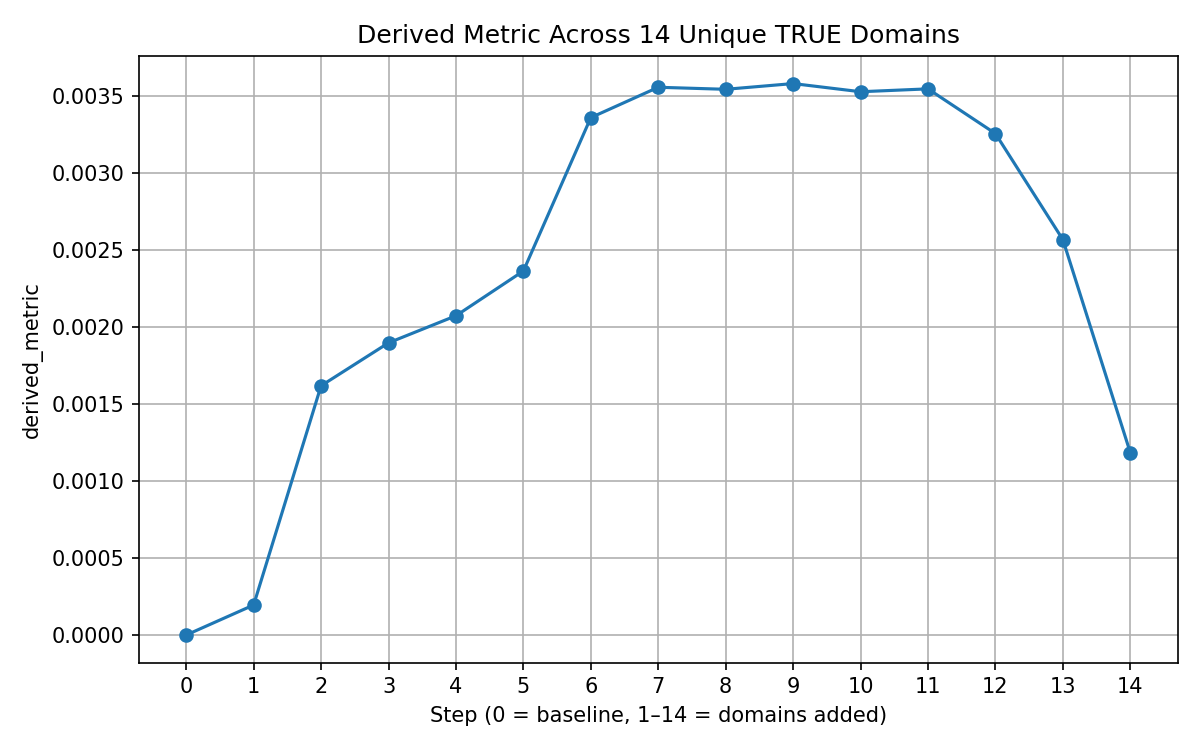

ACTION_COLS (used): ['target_d_1', 'target_d_2', 'target_d_3', 'target_d_4', 'target_d_5', 'target_d_6', 'target_d_7', 'target_d_8', 'target_d_9', 'target_d_10', 'target_d_11', 'target_d_12', 'target_d_13', 'target_d_14']
LOCKED_NON_ACTIONS (forced to 0): ['d_10_ind', 'd_10_score', 'd_11_ind', 'd_11_score', 'd_12_ind', 'd_12_score', 'd_13_ind', 'd_13_score', 'd_14_ind', 'd_14_score'] ... + more


In [ ]:
# === Strict 14-step greedy over TRUE action columns only ===
import re, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from IPython.display import display, Image

# ----- 0) Resolve ACTION_COLS strictly -----
def get_action_cols_from_notebook():
    # Priority 1: from instantiated evaluator CAO mapping
    if 'esp_evaluator' in globals():
        try:
            acts = list(esp_evaluator.cao_mapping.get('actions', []))
            if acts:
                return acts
        except Exception:
            pass
    # Priority 2: from class helper with your config
    if 'UnileafPrescriptor' in globals() and 'config' in globals():
        try:
            acts = list(UnileafPrescriptor.get_action_field_names(config))
            if acts:
                return acts
        except Exception:
            pass
    return None

# pick a base df that exists in your notebook
if 'sample_context_action_df' in globals():
    base_df = sample_context_action_df.copy()
    raise RuntimeError("Need `sample_context_action_df` or `evaluation_df` defined earlier.")

ACTION_COLS = get_action_cols_from_notebook()
if ACTION_COLS is None:
    # Fallback: set explicitly if you know them
    ACTION_COLS = [f"target_d_{i}" for i in range(1, 15)]  # <-- edit if your names differ

# Sanity: actions must exist in df
missing_actions = [c for c in ACTION_COLS if c not in base_df.columns]
if missing_actions:
    raise ValueError(f"These ACTION_COLS are not in the DataFrame: {missing_actions}")

# ----- 1) Compute NON-ACTIONS to lock at 0 -----
# Anything that looks like an action-like feature but is NOT a true action
# e.g., *_ind, *_score, *_prob, *_pct, *_mean, *_std, etc.
bad_suffixes = (
    "_ind","_indicator","_score","_prob","_pct","_perc","_mean","_std","_z",
    "_min","_max","_sum","_count","_rate"
)
def is_bad_derivative(col):
    lc = col.lower()
    return lc.endswith(bad_suffixes) or any(k in lc for k in ("indicator","prob","percent","pct","zscore"))

LOCKED_NON_ACTIONS = [c for c in base_df.columns if is_bad_derivative(c) and c not in ACTION_COLS]

# ----- 2) Build fake "never-done-anything" context row -----
def build_fake_context(context_df: pd.DataFrame) -> pd.Series:
    fake = {}
    for c in context_df.columns:
        s = context_df[c]
        if pd.api.types.is_numeric_dtype(s):
            fake[c] = float(s.median()) if s.notna().any() else 0.0
        else:
            vals = s.dropna().tolist()
            fake[c] = Counter(vals).most_common(1)[0][0] if vals else ""
    return pd.Series(fake)

# separate context from actions
CONTEXT_COLS = [c for c in base_df.columns if c not in ACTION_COLS]
fake_ctx = build_fake_context(base_df[CONTEXT_COLS])

# Lock history/usage-ish to 0 for a "never-done" patient
for c in list(fake_ctx.index):
    lc = c.lower()
    if any(p in lc for p in ("n_sessions","num_","count_","_count","total_","_total","history","usage","minutes","streak")):
        try: fake_ctx[c] = 0
        except: pass

# ----- 3) Scoring wrapper using your notebook's helper -----
def get_scored(df):
    preds = get_predictions(all_predictors, df, encoder)
    out = df.join(preds)
    # Use derived_metric directly if present, else compute as average of domain preds
    if "derived_metric" not in out.columns:
        # Average all numeric prediction columns (exclude housekeeping)
        pred_cols = [c for c in out.columns if pd.api.types.is_numeric_dtype(out[c]) and c not in df.columns]
        if not pred_cols:
            raise ValueError("No prediction columns found; ensure get_predictions returns numeric outputs.")
        out["derived_metric"] = out[pred_cols].mean(axis=1)
    out["__score__"] = out["derived_metric"]
    return out

# ----- 4) Prepare initial state: actions OFF, locked non-actions OFF -----
state = fake_ctx.to_dict()
for a in ACTION_COLS:
    state[a] = 0
for b in LOCKED_NON_ACTIONS:
    # ensure these never influence selection; hold them at 0
    if pd.api.types.is_numeric_dtype(base_df[b]):
        state[b] = 0

# ----- 5) Fixed 14 steps, each step toggles ONE NEW TRUE ACTION ONLY -----
remaining = ACTION_COLS.copy()
trajectory = []

# step 0 baseline
s0 = get_scored(pd.DataFrame([state])).iloc[0]
trajectory.append({"step": 0, "added": None, "derived_metric": float(s0["__score__"])})

for step in range(1, 15):  # 1..14
    if not remaining:
        # if fewer than 14 true actions exist, just carry forward the last score
        last = trajectory[-1].copy()
        last["step"] = step
        trajectory.append(last)
        continue

    trials = []
    labels = []
    for dom in remaining:
        t = state.copy()
        # lock non-actions to zero on every trial (belt-and-suspenders)
        for b in LOCKED_NON_ACTIONS:
            if b in t:
                t[b] = 0
        # turn on exactly ONE candidate action
        t[dom] = 1
        trials.append(t); labels.append(dom)

    scored = get_scored(pd.DataFrame(trials)).reset_index(drop=True)
    top_idx = scored["__score__"].values.argmax()
    chosen_dom = labels[top_idx]
    chosen_score = float(scored.loc[top_idx, "__score__"])

    # guardrail: ensure we're only ever choosing a TRUE action
    if chosen_dom not in ACTION_COLS:
        raise AssertionError(f"Chosen domain '{chosen_dom}' is not in ACTION_COLS! Check column resolution.")

    # commit
    state[chosen_dom] = 1
    remaining.remove(chosen_dom)
    trajectory.append({"step": step, "added": chosen_dom, "derived_metric": chosen_score})

trajectory_df = pd.DataFrame(trajectory)
display(trajectory_df[["step","added","derived_metric"]])

# ----- 6) Plot (and save so it always renders) -----
fig = plt.figure(figsize=(8,5))
plt.plot(trajectory_df["step"], trajectory_df["derived_metric"], marker="o")
plt.title("Derived Metric Across 14 Unique TRUE Domains")
plt.xlabel("Step (0 = baseline, 1–14 = domains added)")
plt.ylabel("derived_metric")
plt.xticks(np.arange(0, 15, 1))
plt.grid(True)
plt.tight_layout()
fig.savefig("derived_metric_trajectory.png", dpi=150)
plt.close(fig)

display(Image("derived_metric_trajectory.png"))